# Paper Figures

In [1]:
import os
from collections import defaultdict
import json
import numpy as np
import pandas as pd
from scipy import stats
import torch

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.lines import Line2D

from vis import (
    plot_top_bottom_evolution, 
    table_generator_three_way, 
    table_generator_two_way, 
    table_generator_three_way_bloom,
    table_generator_two_way_bloom
)

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## IE Evolution of Top-5 and Bottom-5 Features

/mnt/u14157_ic_nlp_001_files_nfs/nlpdata1/home/bayazit/model-diff/vis.py:629: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.

/mnt/u14157_ic_nlp_001_files_nfs/nlpdata1/home/ba

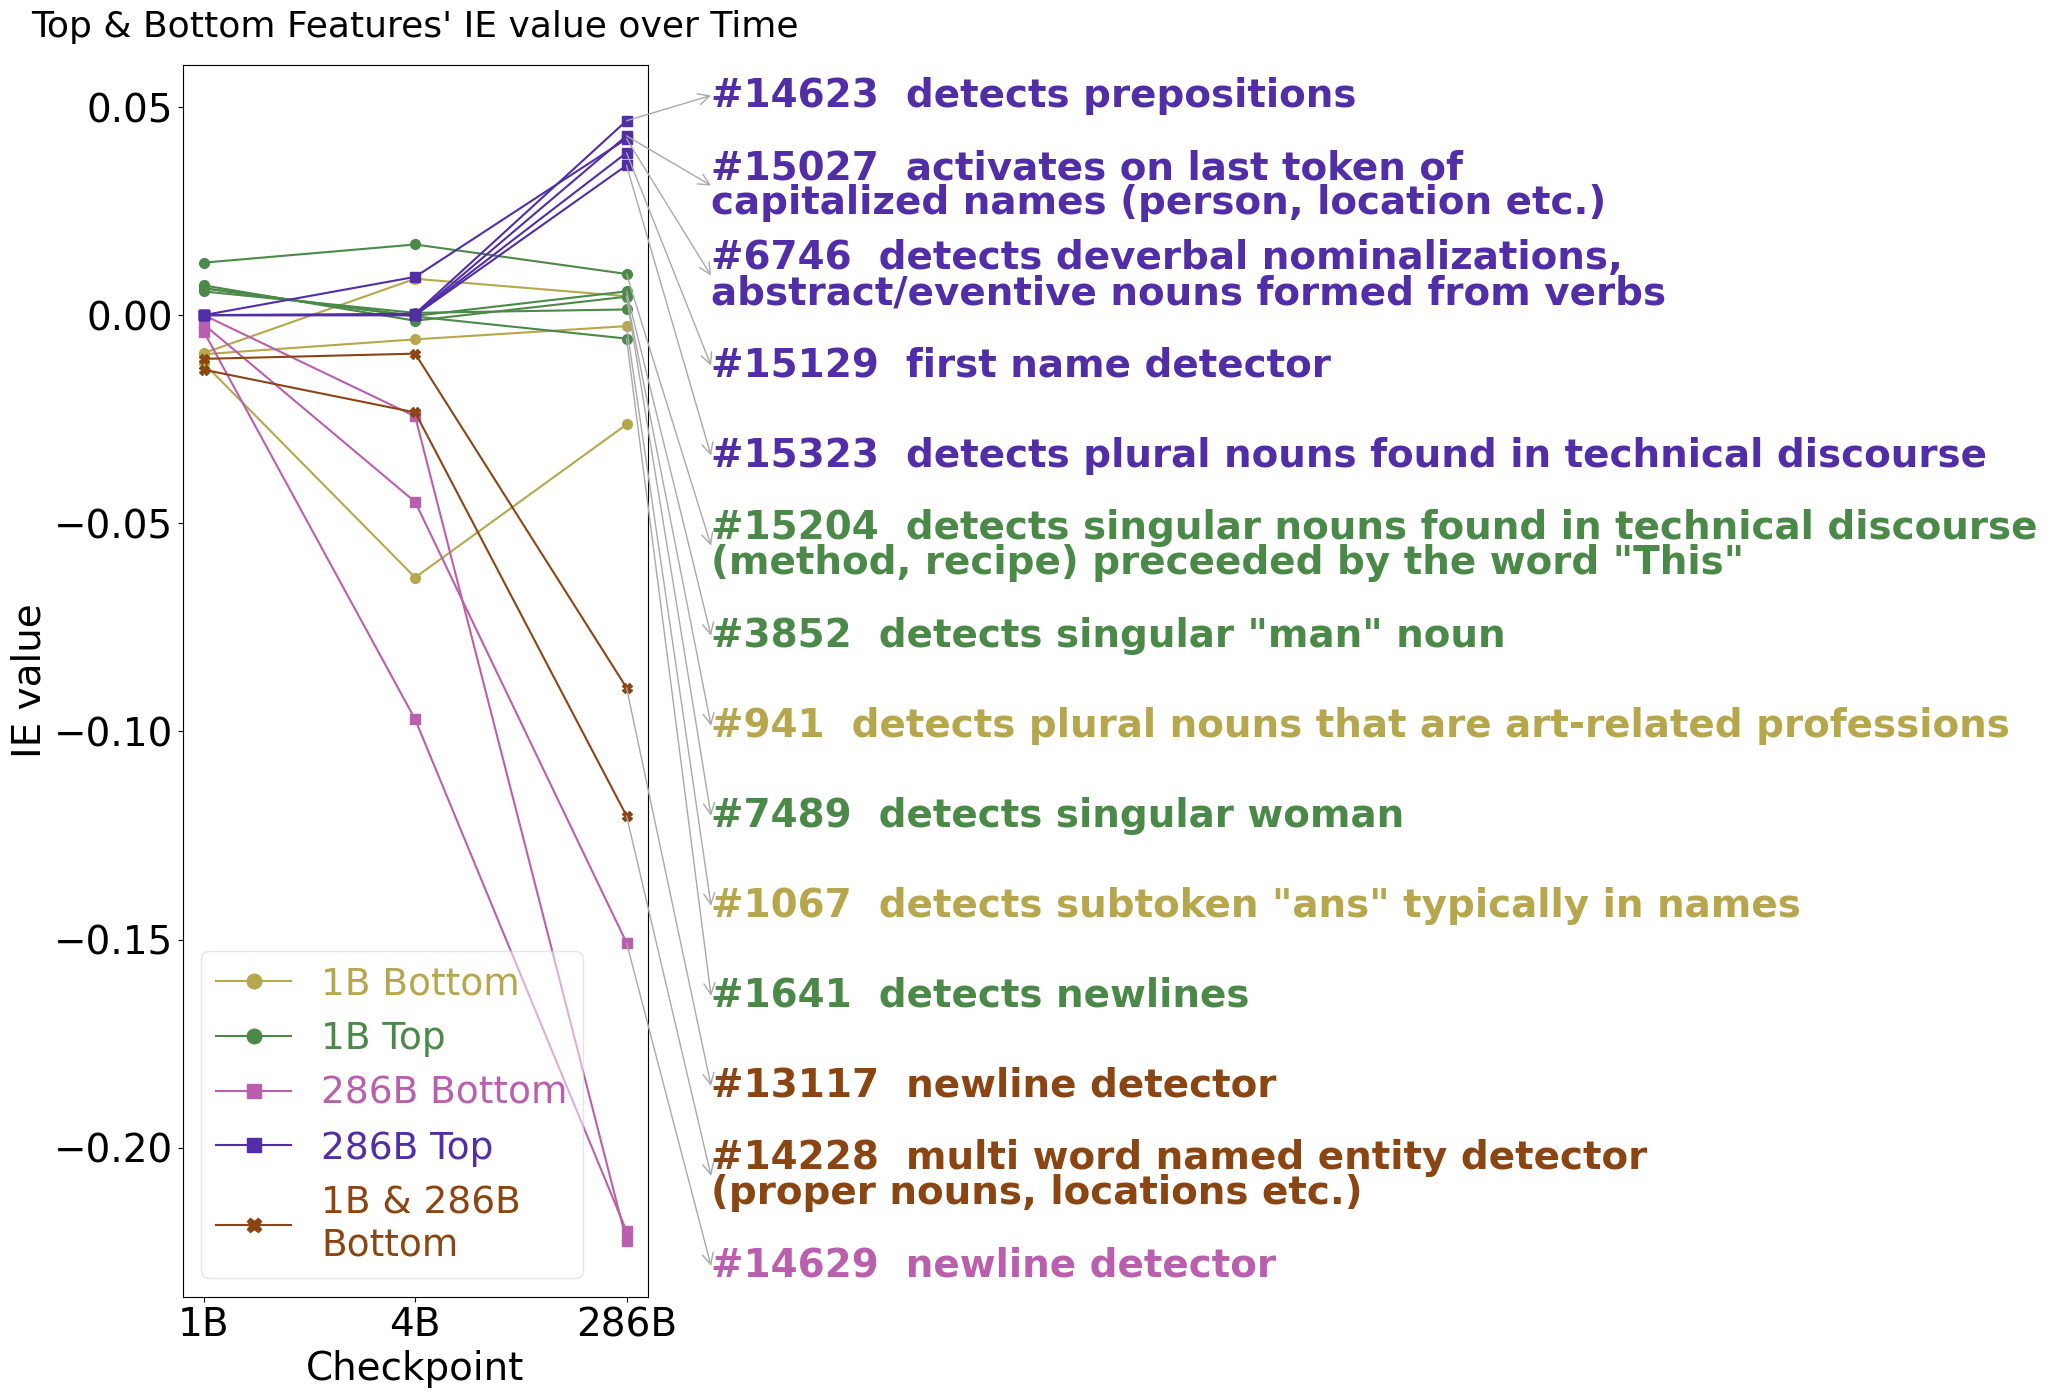

In [2]:
plot_top_bottom_evolution(
    version_num   = 446,
    max_examples  = 3469,
    node_threshold= 0.1,
    task          = "subjectverb",
    ckpt_num      = 20,
    top_k         = 5,
    ckpt_tokens   = ['1B', '4B', '286B'],
    figsize       = (6,16),
    save_path     = "figs/ie_evolution/top5_bottom5_pythia.pdf",
    fontsize      = 28,
)

/mnt/u14157_ic_nlp_001_files_nfs/nlpdata1/home/bayazit/model-diff/vis.py:629: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.

/mnt/u14157_ic_nlp_001_files_nfs/nlpdata1/home/ba

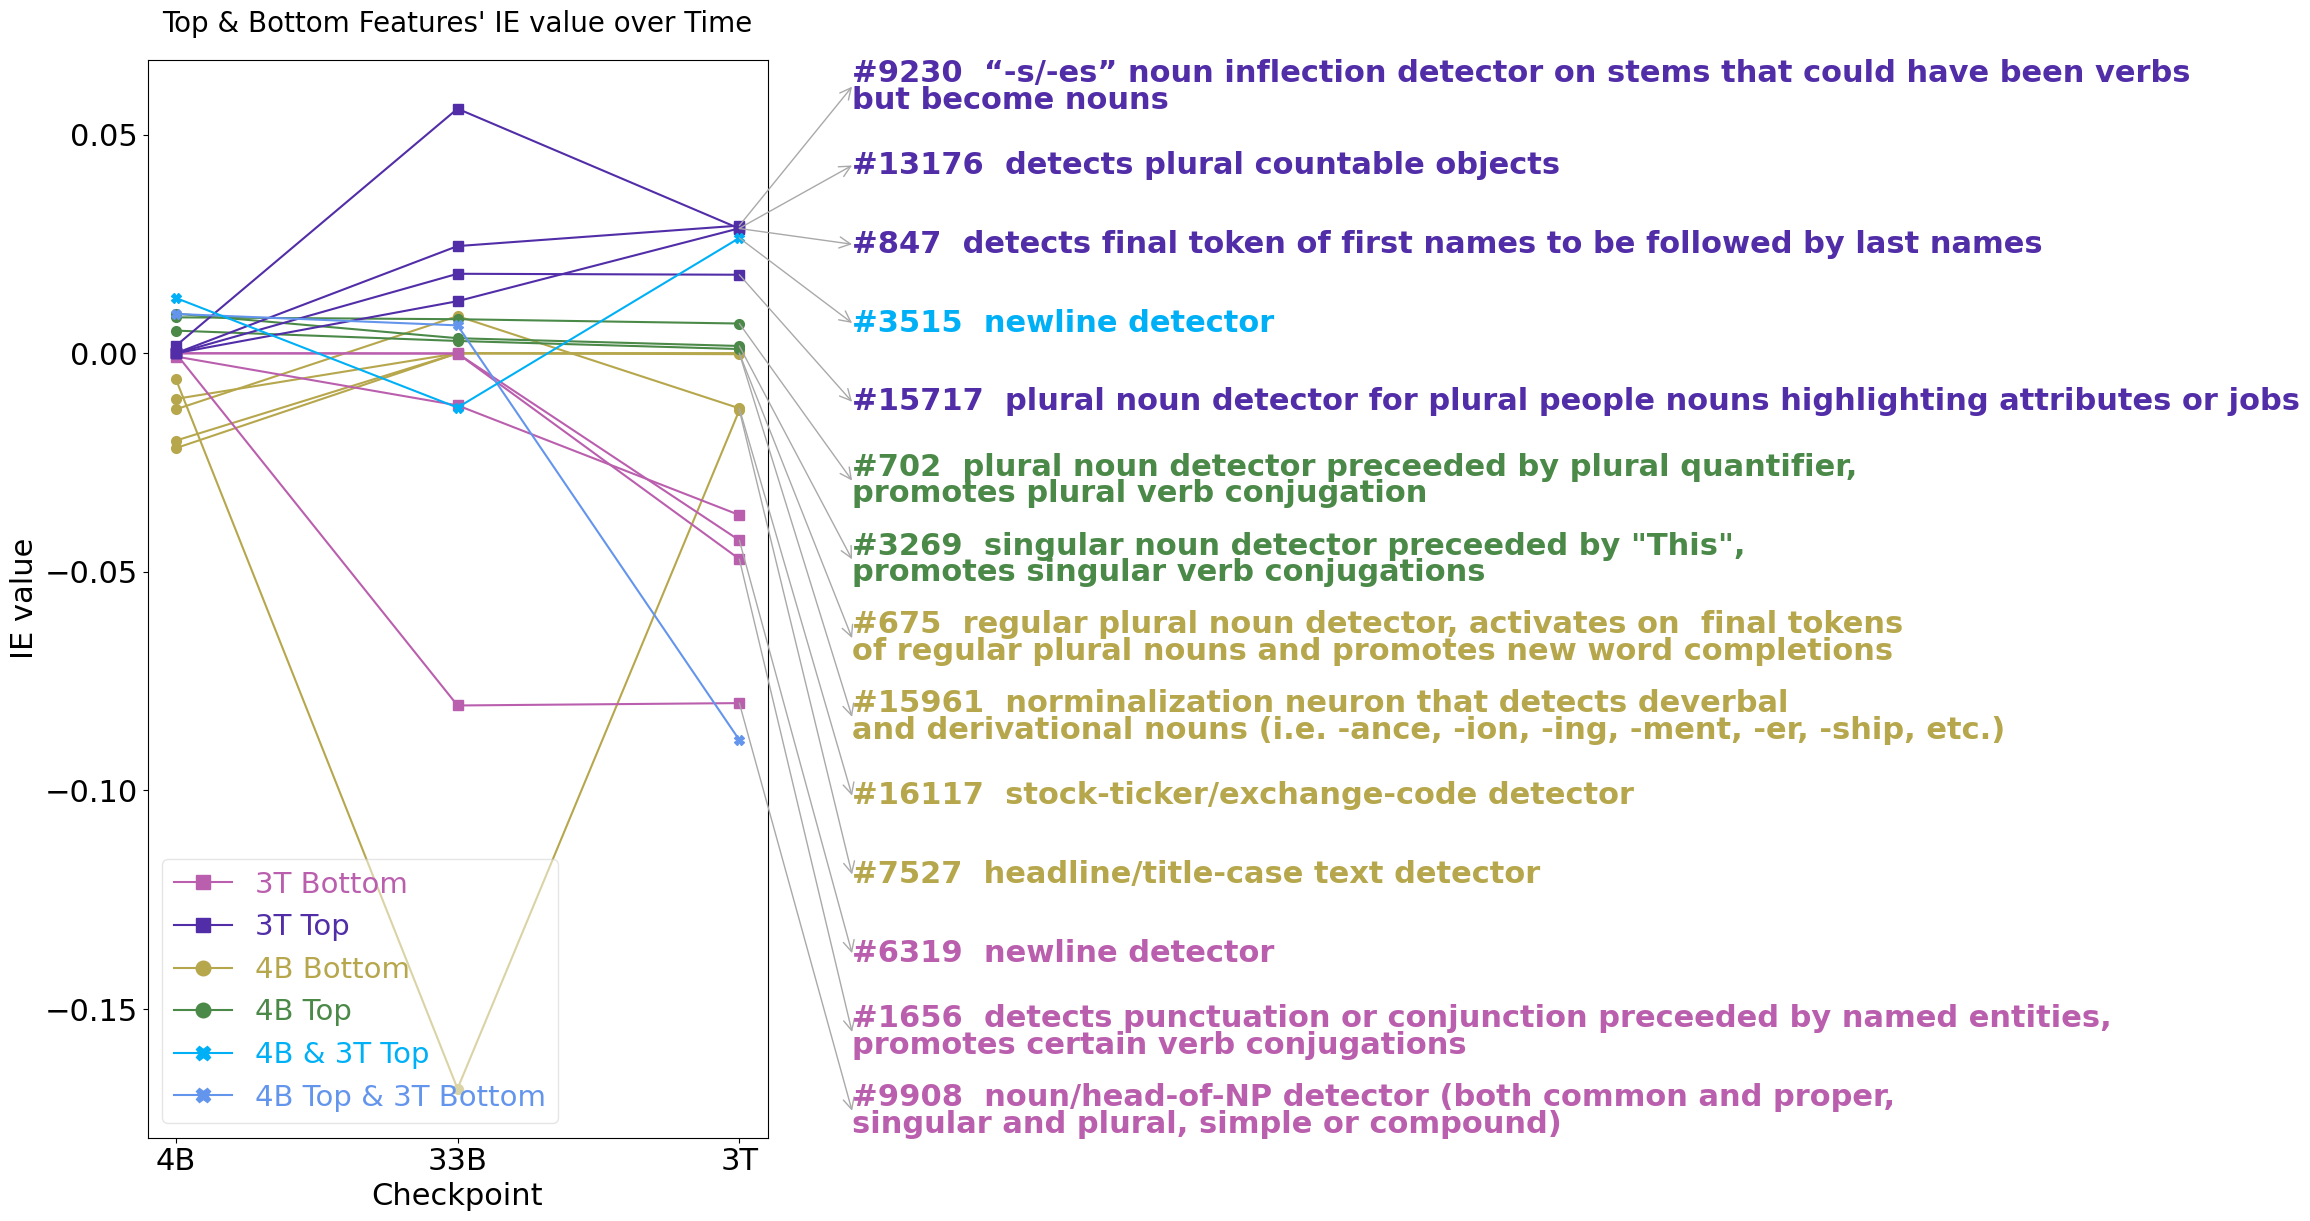

In [3]:
plot_top_bottom_evolution(
    version_num   = 447,
    max_examples  = 3469,
    node_threshold= 0.1,
    task          = "subjectverb",
    ckpt_num      = 20,
    top_k         = 5,
    ckpt_tokens   = ['4B', '33B', '3T'],
    figsize       = (8,14),
    save_path     = "figs/ie_evolution/top5_bottom5_olmo.pdf"
)

## Pythia Top-10 & Top-100 3D plot of RelIE in 3-way comparison

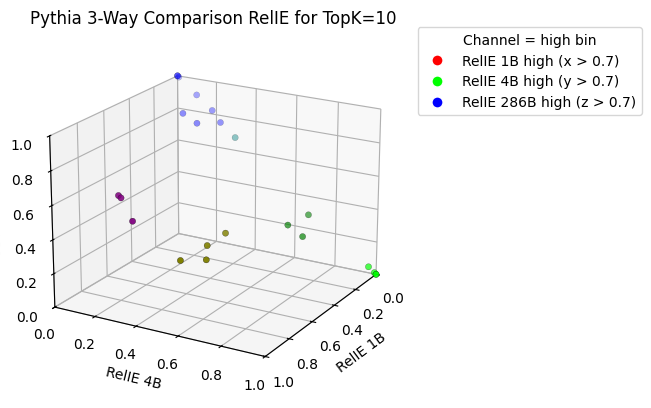

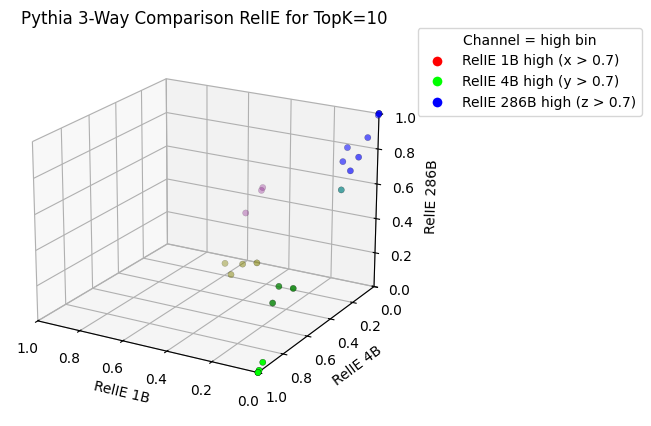

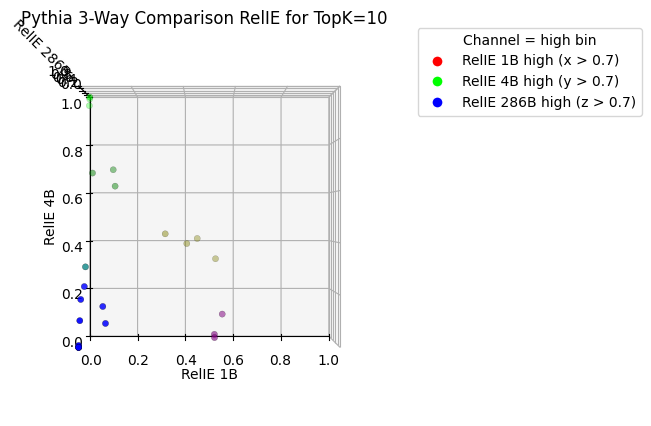

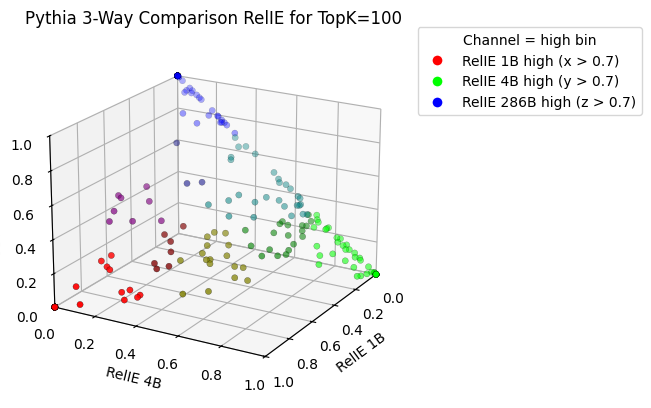

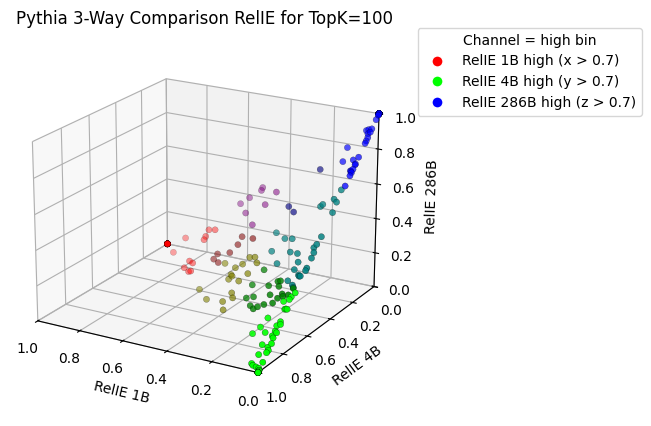

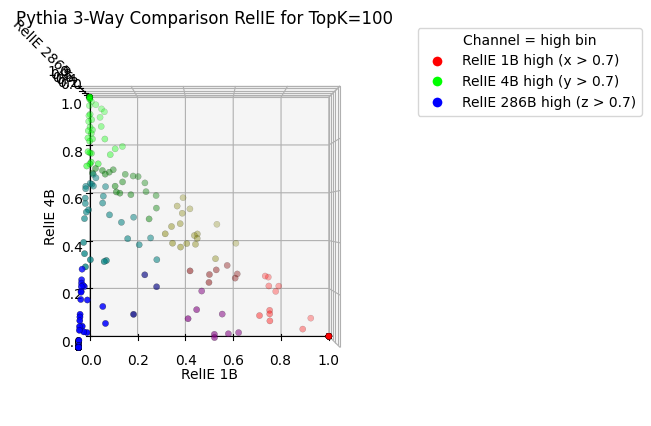

In [4]:
version_num = 446
base_dir = "./workspace/logs/ie_dicts_zeroshot"
save_dir = f"{base_dir}/version_{version_num}"
node_threshold = 0.1
ckpt_num = 20
max_examples = 3469
task = "subjectverb"

for top_k in [10, 100]:
    csv_path = f"{save_dir}/latents_{task}_ckpt{ckpt_num}_thresh{node_threshold}_n{max_examples}_topk{top_k}.csv"
    df = pd.read_csv(csv_path)
    df['rel_ie_array'] = df['rel_ie_value'].str.strip('[]') \
                                        .apply(lambda s: np.fromstring(s, sep=' '))
    
    coords = np.vstack(df['rel_ie_array'].values)
    x, y, z = coords[:,0], coords[:,1], coords[:,2]

    # (elev, azim) pairs
    views = [
        (20,  30),   # front-angle
        (20, 120),   # side-ish
        (90,  -90),  # top-view
    ]

    for elev, azim in views:
        fig = plt.figure(constrained_layout=True)
        ax  = fig.add_subplot(111, projection='3d')
        
        # split at .3 and .7 => bins 0:[0 – .3], 1:(.3 – .7], 2:(.7 – 1]
        xb = np.digitize(x, [0.3, 0.7])
        yb = np.digitize(y, [0.3, 0.7])
        zb = np.digitize(z, [0.3, 0.7])

        # 2) map low=>0, mid=>.5, high=>1 into RGB channels
        r = xb / 2.0      # 0=>0, 1=>.5,   2=>1.0
        g = yb / 2.0
        b = zb / 2.0
        colors = np.stack([r, g, b], axis=1)

        # 3) scatter with those colors
        ax.scatter(x, y, z, c=colors, marker='o', s=20, edgecolor='k', linewidth=0.2)
        
        ax.set_xlabel('RelIE 1B')
        ax.set_ylabel('RelIE 4B')
        ax.set_zlabel('RelIE 286B')
        ax.set_xlim(0,1)
        ax.set_ylim(0,1)
        ax.set_zlim(0,1)        

        # smaller pad for the title itself
        ax.set_title(
            f'Pythia 3-Way Comparison RelIE for TopK={top_k}',
            pad=0
        )

        # tighten margins
        # fig.tight_layout(pad=0.25)
        
        legend_elements = [
            Line2D([0], [0],
                marker='o', color='w',
                markerfacecolor=(1,0,0), markersize=8,
                label='RelIE 1B high (x > 0.7)'),
            Line2D([0], [0],
                marker='o', color='w',
                markerfacecolor=(0,1,0), markersize=8,
                label='RelIE 4B high (y > 0.7)'),
            Line2D([0], [0],
                marker='o', color='w',
                markerfacecolor=(0,0,1), markersize=8,
                label='RelIE 286B high (z > 0.7)'),
        ]
        
        ax.legend(
            handles=legend_elements,
            title='Channel = high bin',
            loc='upper left',             # legend “corner” anchored to:
            bbox_to_anchor=(1.05, 1.0),   # (x, y) in axis‐fraction coords
            borderaxespad=0.,             # pad between axes and legend
        )

        ax.view_init(elev=elev, azim=azim)
        full_path = f"figs/pyhtia1b_3compar_RelIE_topk{top_k}_elev{elev}_azim{azim}_full.png",
        crop_path = f"figs/pyhtia1b_3compar_RelIE_topk{top_k}_elev{elev}_azim{azim}_cropped.png",
        fig.savefig(
            f"figs/pyhtia1b_3compar_RelIE_topk{top_k}_elev{elev}_azim{azim}.png",
            pad_inches=0.0
        )

## BLOOM MultiBLiMP Overlap Multilinguality Scores

### 2-way

########################################
task:  SV-#
--------------------
version_num:  387
# of feats for both models for multiblimp_eng_SV-#:  18
# of feats for both models for multiblimp_fra_SV-#:  19
# of feats for both models for multiblimp_spa_SV-#:  18
# of feats for both models for multiblimp_por_SV-#:  19
# of feats for both models for multiblimp_arb_SV-#:  18
# of feats for both models for multiblimp_hin_SV-#:  16


/tmp/ipykernel_4547/3682069170.py:21: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.

/tmp/ipykernel_4547/3682069170.py:21: FutureWarning:

You are using `torch.load` with `we

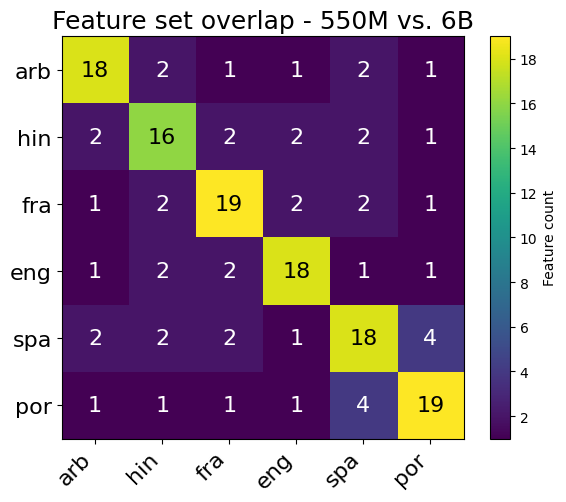

--------------------
version_num:  400
# of feats for both models for multiblimp_eng_SV-#:  16
# of feats for both models for multiblimp_fra_SV-#:  16
# of feats for both models for multiblimp_spa_SV-#:  19
# of feats for both models for multiblimp_por_SV-#:  18
# of feats for both models for multiblimp_arb_SV-#:  16
# of feats for both models for multiblimp_hin_SV-#:  16


/tmp/ipykernel_4547/3682069170.py:21: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.

/tmp/ipykernel_4547/3682069170.py:21: FutureWarning:

You are using `torch.load` with `we

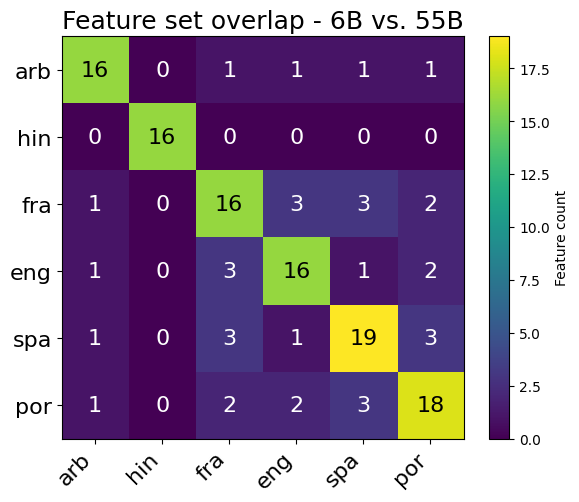

--------------------
version_num:  409
# of feats for both models for multiblimp_eng_SV-#:  17
# of feats for both models for multiblimp_fra_SV-#:  18
# of feats for both models for multiblimp_spa_SV-#:  20
# of feats for both models for multiblimp_por_SV-#:  18
# of feats for both models for multiblimp_arb_SV-#:  18
# of feats for both models for multiblimp_hin_SV-#:  15


/tmp/ipykernel_4547/3682069170.py:21: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.

/tmp/ipykernel_4547/3682069170.py:21: FutureWarning:

You are using `torch.load` with `we

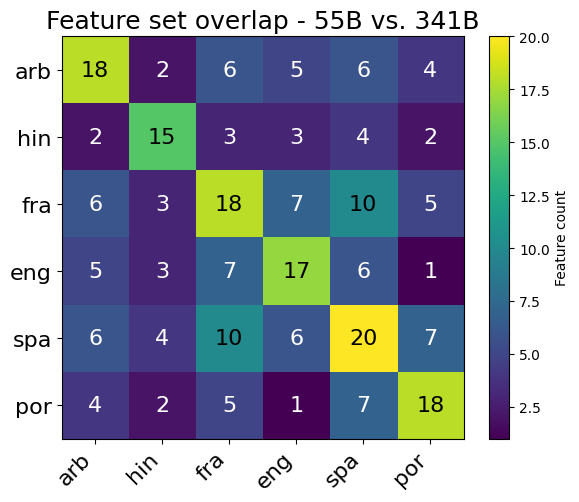

########################################
task:  SV-G
--------------------
version_num:  387
# of feats for both models for multiblimp_por_SV-G:  20
# of feats for both models for multiblimp_arb_SV-G:  18
# of feats for both models for multiblimp_hin_SV-G:  15


/tmp/ipykernel_4547/3682069170.py:21: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.

/tmp/ipykernel_4547/3682069170.py:21: FutureWarning:

You are using `torch.load` with `we

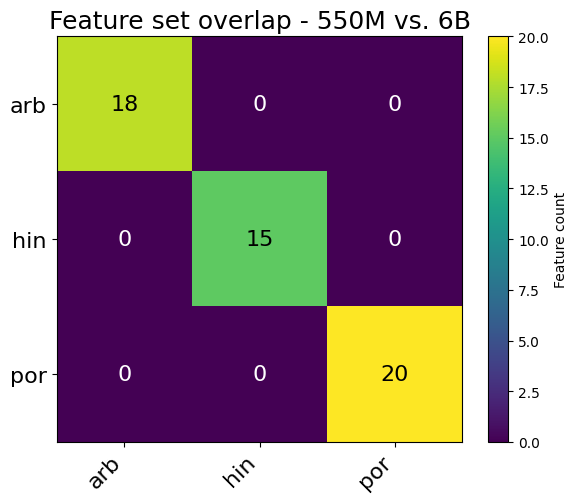

--------------------
version_num:  400
# of feats for both models for multiblimp_por_SV-G:  17
# of feats for both models for multiblimp_arb_SV-G:  14
# of feats for both models for multiblimp_hin_SV-G:  14


/tmp/ipykernel_4547/3682069170.py:21: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.

/tmp/ipykernel_4547/3682069170.py:21: FutureWarning:

You are using `torch.load` with `we

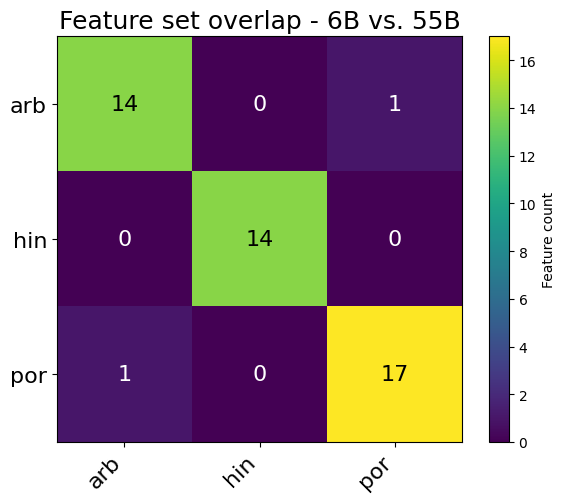

--------------------
version_num:  409
# of feats for both models for multiblimp_por_SV-G:  17
# of feats for both models for multiblimp_arb_SV-G:  17
# of feats for both models for multiblimp_hin_SV-G:  16


/tmp/ipykernel_4547/3682069170.py:21: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.

/tmp/ipykernel_4547/3682069170.py:21: FutureWarning:

You are using `torch.load` with `we

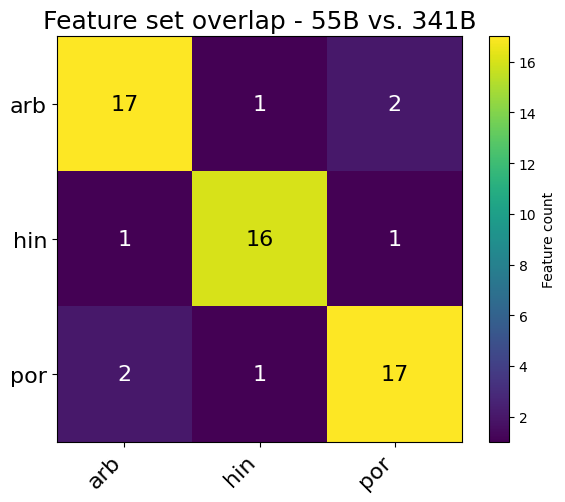

########################################
task:  SV-P
--------------------
version_num:  387
# of feats for both models for multiblimp_eng_SV-P:  19
# of feats for both models for multiblimp_fra_SV-P:  13
# of feats for both models for multiblimp_spa_SV-P:  18
# of feats for both models for multiblimp_por_SV-P:  18
# of feats for both models for multiblimp_arb_SV-P:  20
# of feats for both models for multiblimp_hin_SV-P:  13


/tmp/ipykernel_4547/3682069170.py:21: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.

/tmp/ipykernel_4547/3682069170.py:21: FutureWarning:

You are using `torch.load` with `we

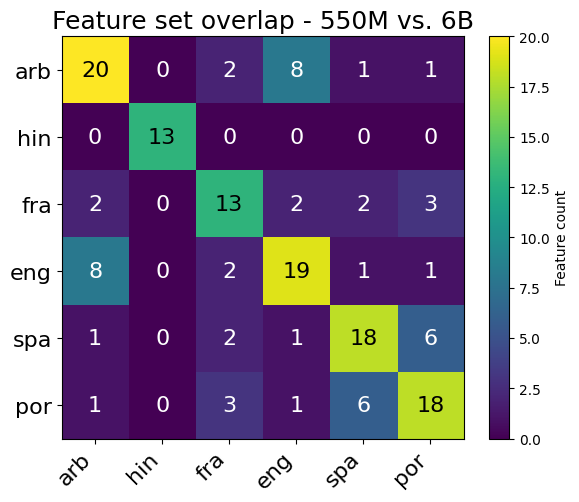

--------------------
version_num:  400
# of feats for both models for multiblimp_eng_SV-P:  17
# of feats for both models for multiblimp_fra_SV-P:  12
# of feats for both models for multiblimp_spa_SV-P:  16
# of feats for both models for multiblimp_por_SV-P:  15
# of feats for both models for multiblimp_arb_SV-P:  18
# of feats for both models for multiblimp_hin_SV-P:  14


/tmp/ipykernel_4547/3682069170.py:21: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.

/tmp/ipykernel_4547/3682069170.py:21: FutureWarning:

You are using `torch.load` with `we

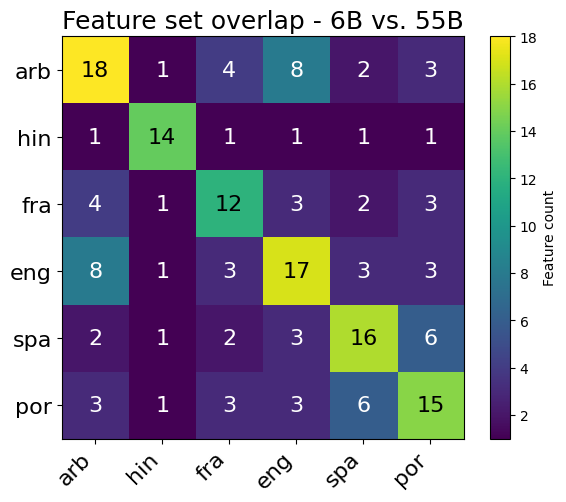

--------------------
version_num:  409
# of feats for both models for multiblimp_eng_SV-P:  19
# of feats for both models for multiblimp_fra_SV-P:  18
# of feats for both models for multiblimp_spa_SV-P:  17
# of feats for both models for multiblimp_por_SV-P:  18
# of feats for both models for multiblimp_arb_SV-P:  18
# of feats for both models for multiblimp_hin_SV-P:  17


/tmp/ipykernel_4547/3682069170.py:21: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.

/tmp/ipykernel_4547/3682069170.py:21: FutureWarning:

You are using `torch.load` with `we

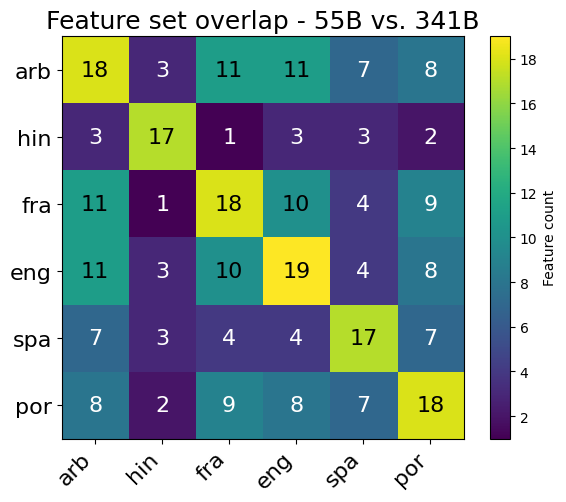

########################################
task:  SV-#
--------------------
version_num:  387
# of feats for both models for multiblimp_eng_SV-#:  162
# of feats for both models for multiblimp_fra_SV-#:  171
# of feats for both models for multiblimp_spa_SV-#:  173
# of feats for both models for multiblimp_por_SV-#:  168
# of feats for both models for multiblimp_arb_SV-#:  168
# of feats for both models for multiblimp_hin_SV-#:  169


/tmp/ipykernel_4547/3682069170.py:21: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.

/tmp/ipykernel_4547/3682069170.py:21: FutureWarning:

You are using `torch.load` with `we

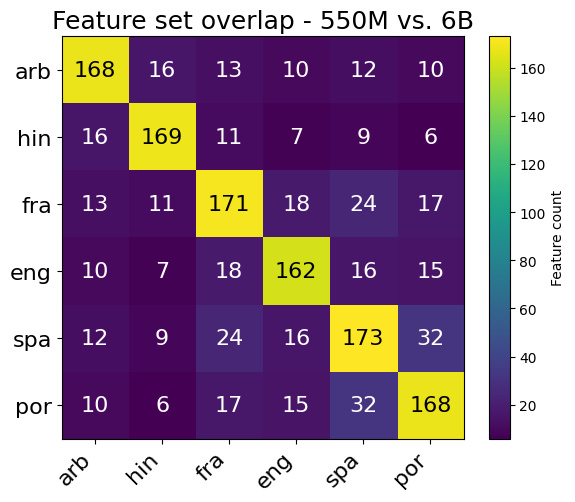

--------------------
version_num:  400
# of feats for both models for multiblimp_eng_SV-#:  158
# of feats for both models for multiblimp_fra_SV-#:  159
# of feats for both models for multiblimp_spa_SV-#:  163
# of feats for both models for multiblimp_por_SV-#:  160
# of feats for both models for multiblimp_arb_SV-#:  166
# of feats for both models for multiblimp_hin_SV-#:  157


/tmp/ipykernel_4547/3682069170.py:21: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.

/tmp/ipykernel_4547/3682069170.py:21: FutureWarning:

You are using `torch.load` with `we

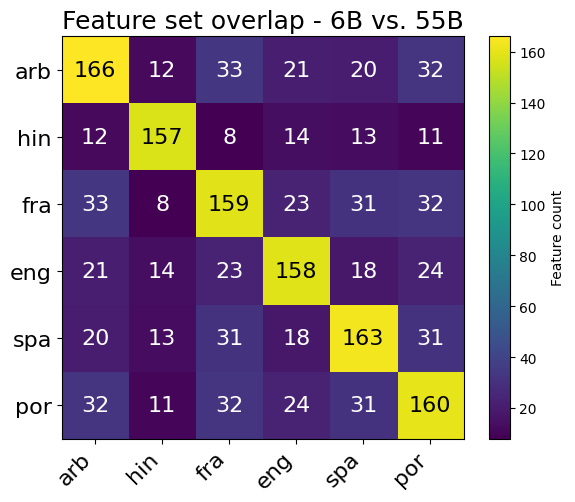

--------------------
version_num:  409
# of feats for both models for multiblimp_eng_SV-#:  154
# of feats for both models for multiblimp_fra_SV-#:  158
# of feats for both models for multiblimp_spa_SV-#:  151
# of feats for both models for multiblimp_por_SV-#:  166
# of feats for both models for multiblimp_arb_SV-#:  164
# of feats for both models for multiblimp_hin_SV-#:  148


/tmp/ipykernel_4547/3682069170.py:21: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.

/tmp/ipykernel_4547/3682069170.py:21: FutureWarning:

You are using `torch.load` with `we

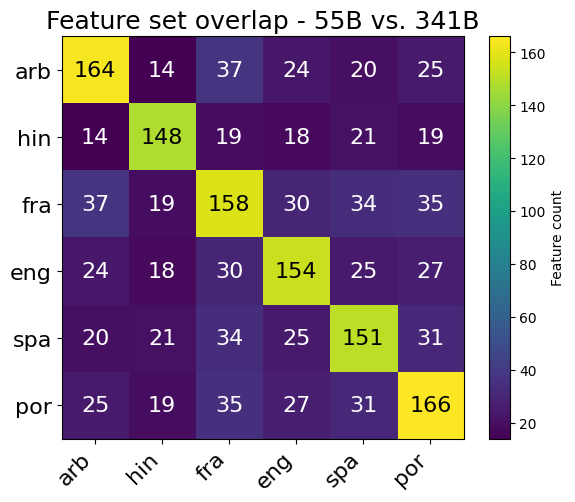

########################################
task:  SV-G
--------------------
version_num:  387
# of feats for both models for multiblimp_por_SV-G:  170
# of feats for both models for multiblimp_arb_SV-G:  169
# of feats for both models for multiblimp_hin_SV-G:  166


/tmp/ipykernel_4547/3682069170.py:21: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.

/tmp/ipykernel_4547/3682069170.py:21: FutureWarning:

You are using `torch.load` with `we

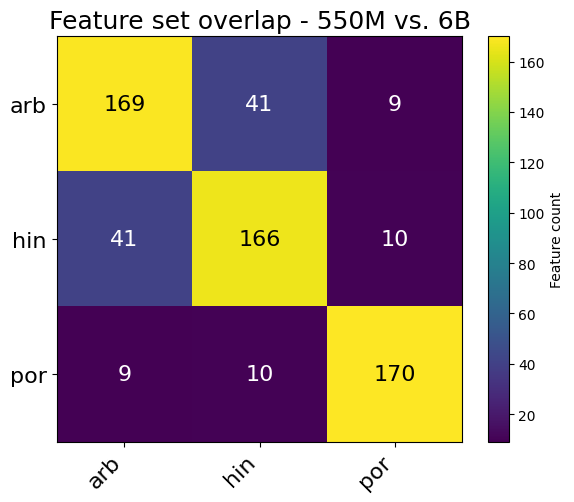

--------------------
version_num:  400
# of feats for both models for multiblimp_por_SV-G:  155
# of feats for both models for multiblimp_arb_SV-G:  171
# of feats for both models for multiblimp_hin_SV-G:  158


/tmp/ipykernel_4547/3682069170.py:21: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.

/tmp/ipykernel_4547/3682069170.py:21: FutureWarning:

You are using `torch.load` with `we

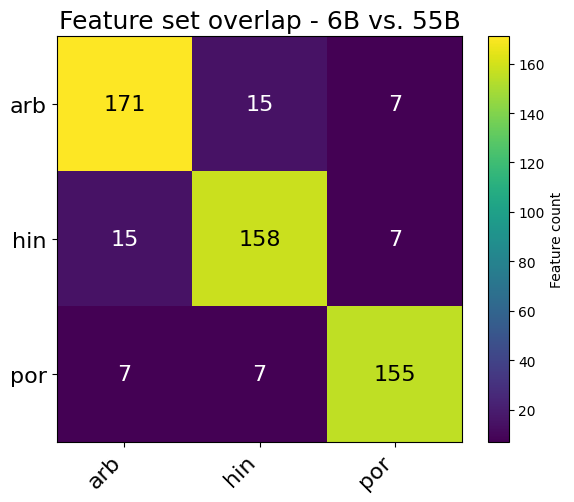

--------------------
version_num:  409
# of feats for both models for multiblimp_por_SV-G:  153
# of feats for both models for multiblimp_arb_SV-G:  163
# of feats for both models for multiblimp_hin_SV-G:  153


/tmp/ipykernel_4547/3682069170.py:21: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.

/tmp/ipykernel_4547/3682069170.py:21: FutureWarning:

You are using `torch.load` with `we

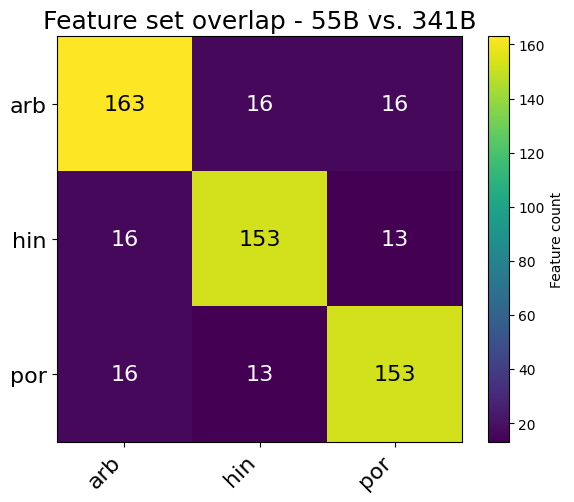

########################################
task:  SV-P
--------------------
version_num:  387
# of feats for both models for multiblimp_eng_SV-P:  170
# of feats for both models for multiblimp_fra_SV-P:  163
# of feats for both models for multiblimp_spa_SV-P:  157
# of feats for both models for multiblimp_por_SV-P:  166
# of feats for both models for multiblimp_arb_SV-P:  169
# of feats for both models for multiblimp_hin_SV-P:  161


/tmp/ipykernel_4547/3682069170.py:21: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.

/tmp/ipykernel_4547/3682069170.py:21: FutureWarning:

You are using `torch.load` with `we

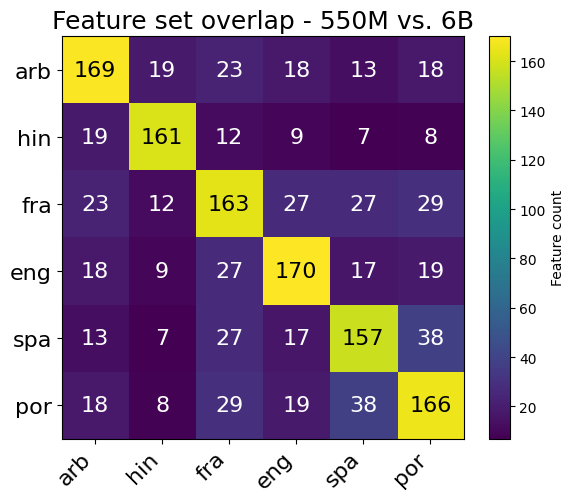

--------------------
version_num:  400
# of feats for both models for multiblimp_eng_SV-P:  158
# of feats for both models for multiblimp_fra_SV-P:  152
# of feats for both models for multiblimp_spa_SV-P:  151
# of feats for both models for multiblimp_por_SV-P:  153
# of feats for both models for multiblimp_arb_SV-P:  168
# of feats for both models for multiblimp_hin_SV-P:  147


/tmp/ipykernel_4547/3682069170.py:21: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.

/tmp/ipykernel_4547/3682069170.py:21: FutureWarning:

You are using `torch.load` with `we

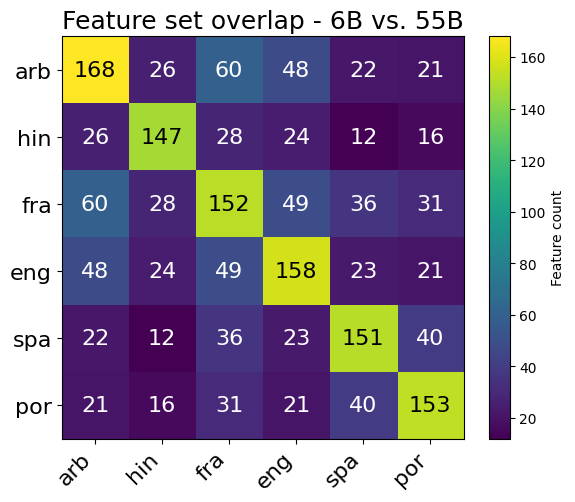

--------------------
version_num:  409
# of feats for both models for multiblimp_eng_SV-P:  156
# of feats for both models for multiblimp_fra_SV-P:  153
# of feats for both models for multiblimp_spa_SV-P:  146
# of feats for both models for multiblimp_por_SV-P:  143
# of feats for both models for multiblimp_arb_SV-P:  155
# of feats for both models for multiblimp_hin_SV-P:  148


/tmp/ipykernel_4547/3682069170.py:21: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.

/tmp/ipykernel_4547/3682069170.py:21: FutureWarning:

You are using `torch.load` with `we

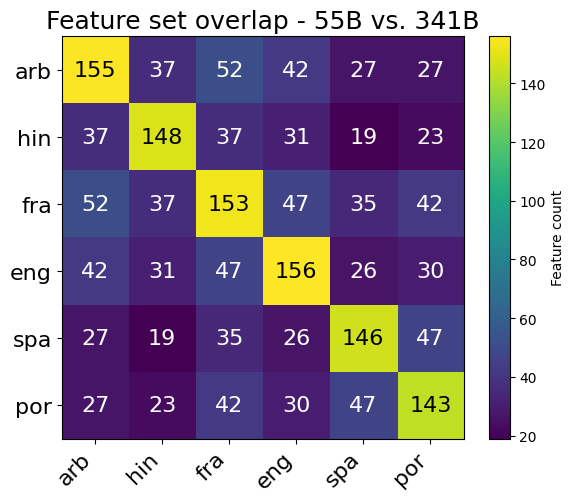

In [5]:
def get_feature_overlap_across_tasks_2way(
        task_list,
        version_num, 
        max_examples,
        submod_layer,
        node_threshold=0.1, 
        ckpt_num=20, 
        top_k=100
    ):
    lang2fidset = {}
    lang2relie = {}
    fid2relie = {}
    fid2reldec = {}
        
    # (1) for all tasks in task_list
    for task in task_list:
        # (1.1) Load IE & Rel IE for all tasks in task_list
        base_dir = "./workspace/logs/ie_dicts_zeroshot"
        save_dir = f"{base_dir}/{version_num}"
        final_path = f"{save_dir}/{task}_ckpt{ckpt_num}_thresh{node_threshold}_n{max_examples}.pt"
        effects = torch.load(final_path)
        
        # (1.2) Make a dict of task -> feat_id set
        csv_path = f"{save_dir}/latents_{task}_ckpt{ckpt_num}_thresh{node_threshold}_n{max_examples}_topk10.csv"
        featdf = pd.read_csv(csv_path)
        lang = task.split("_")[1]
        fid2relie.update(dict(zip(f"{lang}-" + str(featdf['feat_id']), featdf['rel_ie_class'])))
        fid2reldec.update(dict(zip(f"{lang}-" + str(featdf['feat_id']), featdf['rel_dec_norm_class'])))
          
        all_top100_fids = set(
            torch.topk(effects[f"m1_layer{submod_layer}_out"].abs(), k=top_k).indices.tolist()
            + torch.topk(effects[f"m2_layer{submod_layer}_out"].abs(), k=top_k).indices.tolist()
        )
        print(f"# of feats for both models for {task}: ", len(all_top100_fids))
        
        lang2fidset[lang] = all_top100_fids
        
        
    fid2langset = defaultdict(set)
    for lang, fidset in lang2fidset.items():
        for fid in fidset:
            fid2langset[fid].add(lang)
    
    fid2multilangscore = {}
    for fid, langset in fid2langset.items():
        fid2multilangscore[fid] = len(langset)
            
    multilangscore_mean = np.array([len(langset) for fid, langset in fid2langset.items()]).mean()
    # print("Mean: ", multilangscore_mean)
    multilangscore_std = np.array([len(langset) for fid, langset in fid2langset.items()]).std()
    # print("Std: ", multilangscore_std)

    comparison = featdf["comparison"].unique().tolist()[0]
    
    return lang2fidset, comparison

def make_overlap_df(lang2fid, normalize=True):
    langs = sorted(lang2fid)
    if "fra" in langs:
        langs = ["arb", "hin", "fra", "eng", "spa", "por"]
    else:
        langs = ["arb", "hin", "por"]
    mat = np.zeros((len(langs), len(langs)), dtype=float)
    for i, la in enumerate(langs):
        for j, lb in enumerate(langs):
            inter = lang2fid[la] & lang2fid[lb]
            if normalize:
                union = lang2fid[la] | lang2fid[lb]
                mat[i, j] = len(inter) / len(union) if union else 0.0
            else:
                mat[i, j] = len(inter)
    return pd.DataFrame(mat, index=langs, columns=langs)

def plot_heatmap(df, title=None, save_path=None, fontsize=16):
    fig, ax = plt.subplots(figsize=(6, 5))
    im = ax.imshow(df.values, aspect='equal')
    ax.set_xticks(range(len(df.columns)))
    ax.set_xticklabels(df.columns, rotation=45, ha='right', fontsize=fontsize)
    ax.set_yticks(range(len(df.index)))
    ax.set_yticklabels(df.index, fontsize=fontsize)
    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label('Feature count')
    thresh = df.values.max() / 2.0
    for i in range(len(df)):
        for j in range(len(df)):
            val = df.values[i, j]
            text_color = "white" if val < thresh else "black"
            ax.text(
                j, i, f"{int(val)}",
                ha='center', va='center',
                color=text_color,
                fontsize=fontsize
            )
    if title:
        ax.set_title(title, fontsize=fontsize + 2)
    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path, bbox_inches='tight')
    plt.show()


langs=["eng", "fra", "spa", "por", "arb", "hin"]
svg_langs=["por", "arb", "hin"]

tasks=["SV-#", "SV-G", "SV-P"]
task2len = {
    "SV-#": 100,
    "SV-G": 100, 
    "SV-P": 290
}

for top_k in [10, 100]:
    for task in tasks:
        print("#" * 40)
        print("task: ", task)
        for version_num in ["387",  "400", "409"]:
            print("-" * 20)
            print("version_num: ", version_num)
            task_list = []
            if task == "SV-G":
                task_list = [f"multiblimp_{lang}_{task}" for lang in svg_langs]
            else:
                task_list = [f"multiblimp_{lang}_{task}" for lang in langs]
            lang2fid, comparison = get_feature_overlap_across_tasks_2way(
                task_list=task_list,
                version_num="version_" + version_num,
                max_examples=task2len[task],
                submod_layer=12,
                top_k=top_k
            )
            
            overlap_df = make_overlap_df(lang2fid, normalize=False)
            final_path = f"figs/multilingual_overlap_2way/multilang_overlap_topk{top_k}_{task}_{comparison}"
            final_path = final_path.replace("#", "num")
            final_path = final_path.replace(" ", "_")
            final_path = final_path.replace(".", "")
            final_path += ".png"
            plot_heatmap(overlap_df, title=f"Feature set overlap - {comparison}", save_path=final_path)


### 3-way

########################################
task:  SV-#
--------------------
version_num:  454
--------------------
effects_k:  m0_layer12_out
# of feats for both models for multiblimp_eng_SV-#:  10
# of feats for both models for multiblimp_fra_SV-#:  10
# of feats for both models for multiblimp_spa_SV-#:  10
# of feats for both models for multiblimp_por_SV-#:  10
# of feats for both models for multiblimp_arb_SV-#:  10
# of feats for both models for multiblimp_hin_SV-#:  10


/tmp/ipykernel_4547/2792375173.py:28: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.

/tmp/ipykernel_4547/2792375173.py:28: FutureWarning:

You are using `torch.load` with `we

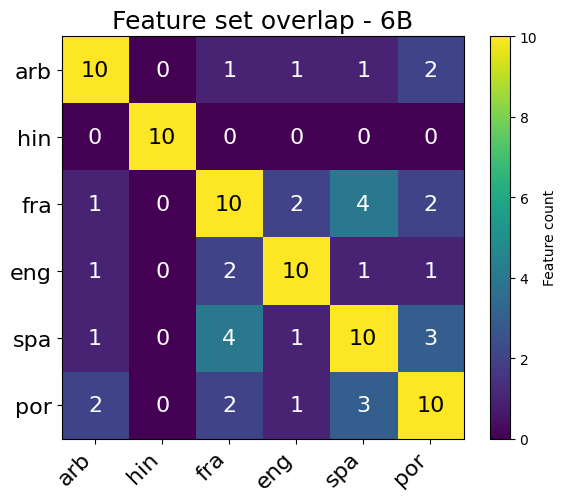

--------------------
effects_k:  m1_layer12_out
# of feats for both models for multiblimp_eng_SV-#:  10
# of feats for both models for multiblimp_fra_SV-#:  10
# of feats for both models for multiblimp_spa_SV-#:  10
# of feats for both models for multiblimp_por_SV-#:  10
# of feats for both models for multiblimp_arb_SV-#:  10
# of feats for both models for multiblimp_hin_SV-#:  10


/tmp/ipykernel_4547/2792375173.py:28: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.

/tmp/ipykernel_4547/2792375173.py:28: FutureWarning:

You are using `torch.load` with `we

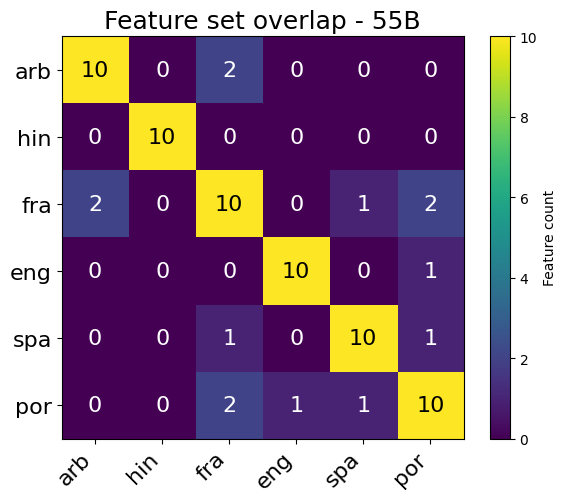

--------------------
effects_k:  m2_layer12_out
# of feats for both models for multiblimp_eng_SV-#:  10
# of feats for both models for multiblimp_fra_SV-#:  10
# of feats for both models for multiblimp_spa_SV-#:  10
# of feats for both models for multiblimp_por_SV-#:  10
# of feats for both models for multiblimp_arb_SV-#:  10
# of feats for both models for multiblimp_hin_SV-#:  10


/tmp/ipykernel_4547/2792375173.py:28: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.

/tmp/ipykernel_4547/2792375173.py:28: FutureWarning:

You are using `torch.load` with `we

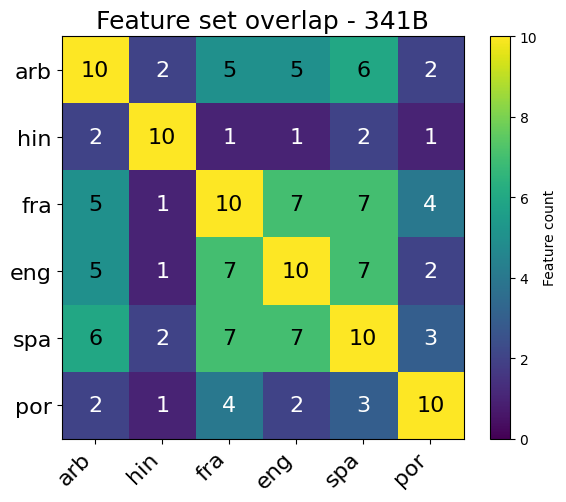

########################################
task:  SV-G
--------------------
version_num:  454
--------------------
effects_k:  m0_layer12_out
# of feats for both models for multiblimp_por_SV-G:  10
# of feats for both models for multiblimp_arb_SV-G:  10
# of feats for both models for multiblimp_hin_SV-G:  10


/tmp/ipykernel_4547/2792375173.py:28: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.

/tmp/ipykernel_4547/2792375173.py:28: FutureWarning:

You are using `torch.load` with `we

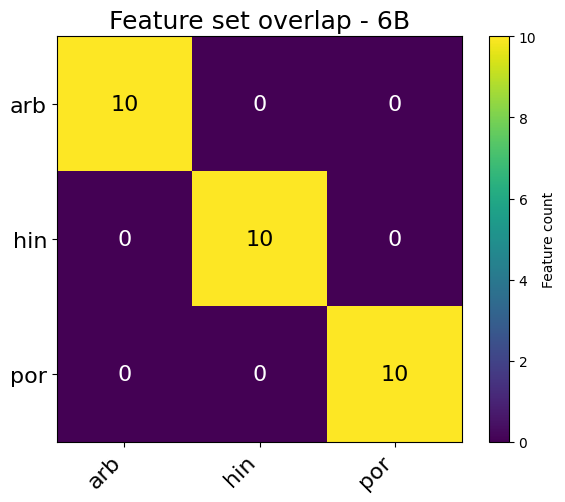

--------------------
effects_k:  m1_layer12_out
# of feats for both models for multiblimp_por_SV-G:  10
# of feats for both models for multiblimp_arb_SV-G:  10
# of feats for both models for multiblimp_hin_SV-G:  10


/tmp/ipykernel_4547/2792375173.py:28: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.

/tmp/ipykernel_4547/2792375173.py:28: FutureWarning:

You are using `torch.load` with `we

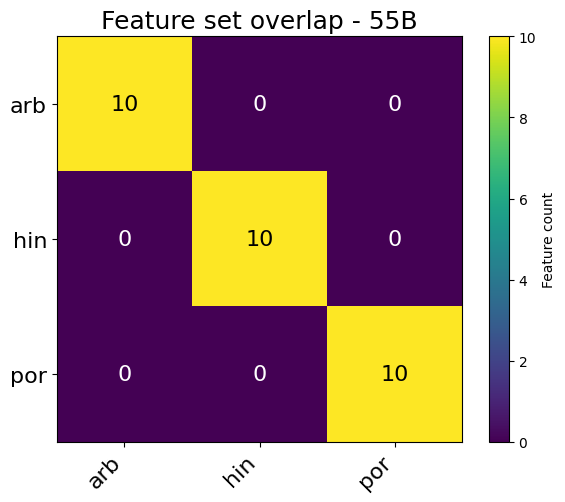

--------------------
effects_k:  m2_layer12_out
# of feats for both models for multiblimp_por_SV-G:  10
# of feats for both models for multiblimp_arb_SV-G:  10
# of feats for both models for multiblimp_hin_SV-G:  10


/tmp/ipykernel_4547/2792375173.py:28: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.

/tmp/ipykernel_4547/2792375173.py:28: FutureWarning:

You are using `torch.load` with `we

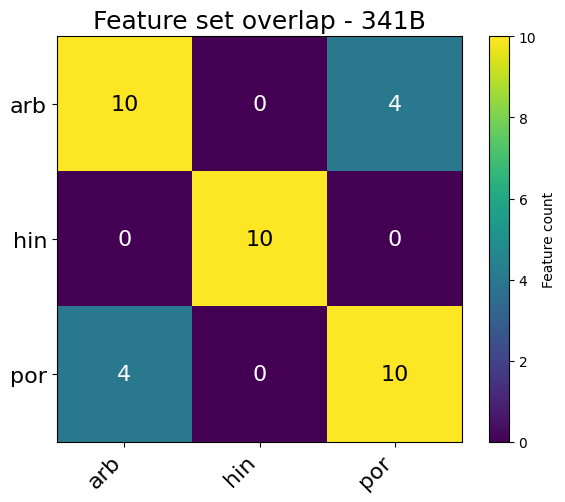

########################################
task:  SV-P
--------------------
version_num:  454
--------------------
effects_k:  m0_layer12_out
# of feats for both models for multiblimp_eng_SV-P:  10
# of feats for both models for multiblimp_fra_SV-P:  10
# of feats for both models for multiblimp_spa_SV-P:  10
# of feats for both models for multiblimp_por_SV-P:  10
# of feats for both models for multiblimp_arb_SV-P:  10
# of feats for both models for multiblimp_hin_SV-P:  10


/tmp/ipykernel_4547/2792375173.py:28: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.

/tmp/ipykernel_4547/2792375173.py:28: FutureWarning:

You are using `torch.load` with `we

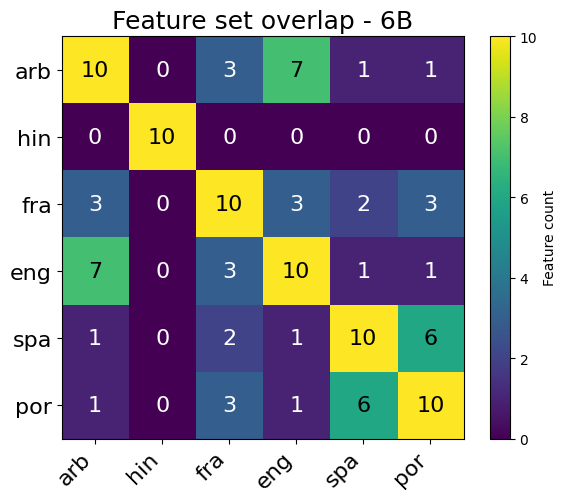

--------------------
effects_k:  m1_layer12_out
# of feats for both models for multiblimp_eng_SV-P:  10
# of feats for both models for multiblimp_fra_SV-P:  10
# of feats for both models for multiblimp_spa_SV-P:  10
# of feats for both models for multiblimp_por_SV-P:  10
# of feats for both models for multiblimp_arb_SV-P:  10
# of feats for both models for multiblimp_hin_SV-P:  10


/tmp/ipykernel_4547/2792375173.py:28: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.

/tmp/ipykernel_4547/2792375173.py:28: FutureWarning:

You are using `torch.load` with `we

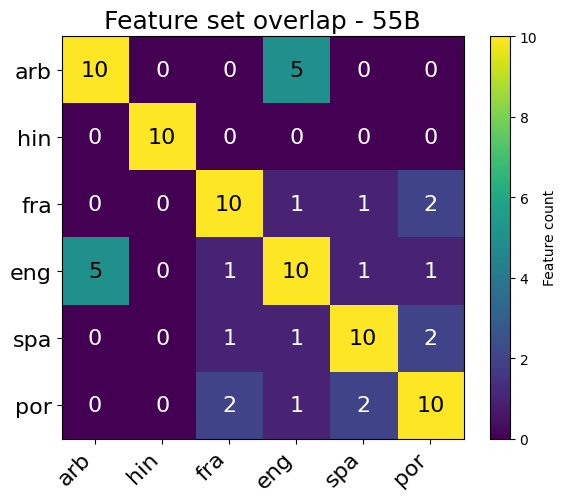

--------------------
effects_k:  m2_layer12_out
# of feats for both models for multiblimp_eng_SV-P:  10
# of feats for both models for multiblimp_fra_SV-P:  10
# of feats for both models for multiblimp_spa_SV-P:  10
# of feats for both models for multiblimp_por_SV-P:  10
# of feats for both models for multiblimp_arb_SV-P:  10
# of feats for both models for multiblimp_hin_SV-P:  10


/tmp/ipykernel_4547/2792375173.py:28: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.

/tmp/ipykernel_4547/2792375173.py:28: FutureWarning:

You are using `torch.load` with `we

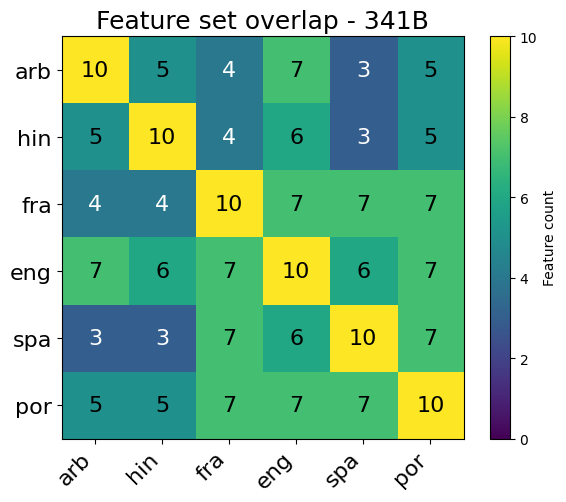

########################################
task:  SV-#
--------------------
version_num:  454
--------------------
effects_k:  m0_layer12_out
# of feats for both models for multiblimp_eng_SV-#:  100
# of feats for both models for multiblimp_fra_SV-#:  100
# of feats for both models for multiblimp_spa_SV-#:  100
# of feats for both models for multiblimp_por_SV-#:  100
# of feats for both models for multiblimp_arb_SV-#:  100
# of feats for both models for multiblimp_hin_SV-#:  100


/tmp/ipykernel_4547/2792375173.py:28: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.

/tmp/ipykernel_4547/2792375173.py:28: FutureWarning:

You are using `torch.load` with `we

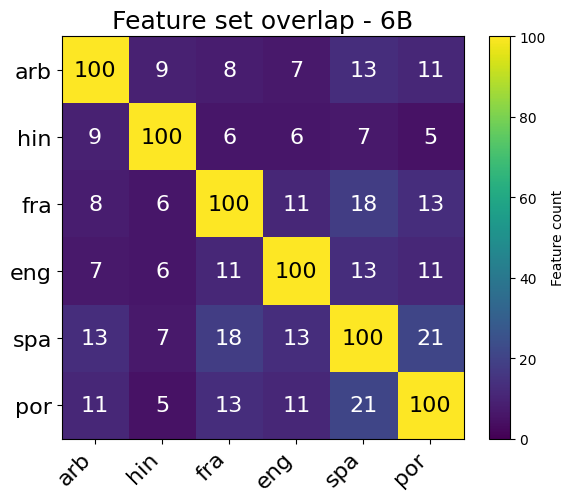

--------------------
effects_k:  m1_layer12_out
# of feats for both models for multiblimp_eng_SV-#:  100
# of feats for both models for multiblimp_fra_SV-#:  100
# of feats for both models for multiblimp_spa_SV-#:  100
# of feats for both models for multiblimp_por_SV-#:  100
# of feats for both models for multiblimp_arb_SV-#:  100
# of feats for both models for multiblimp_hin_SV-#:  100


/tmp/ipykernel_4547/2792375173.py:28: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.

/tmp/ipykernel_4547/2792375173.py:28: FutureWarning:

You are using `torch.load` with `we

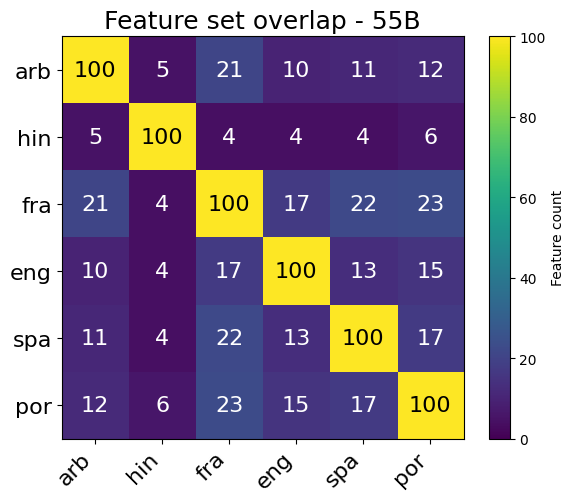

--------------------
effects_k:  m2_layer12_out
# of feats for both models for multiblimp_eng_SV-#:  100
# of feats for both models for multiblimp_fra_SV-#:  100
# of feats for both models for multiblimp_spa_SV-#:  100
# of feats for both models for multiblimp_por_SV-#:  100
# of feats for both models for multiblimp_arb_SV-#:  100
# of feats for both models for multiblimp_hin_SV-#:  100


/tmp/ipykernel_4547/2792375173.py:28: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.

/tmp/ipykernel_4547/2792375173.py:28: FutureWarning:

You are using `torch.load` with `we

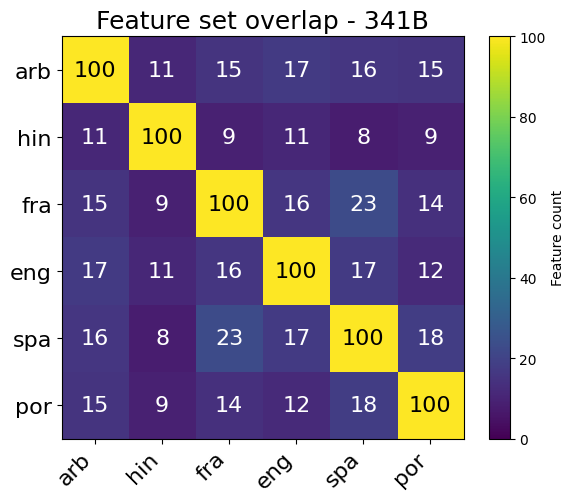

########################################
task:  SV-G
--------------------
version_num:  454
--------------------
effects_k:  m0_layer12_out
# of feats for both models for multiblimp_por_SV-G:  100
# of feats for both models for multiblimp_arb_SV-G:  100
# of feats for both models for multiblimp_hin_SV-G:  100


/tmp/ipykernel_4547/2792375173.py:28: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.

/tmp/ipykernel_4547/2792375173.py:28: FutureWarning:

You are using `torch.load` with `we

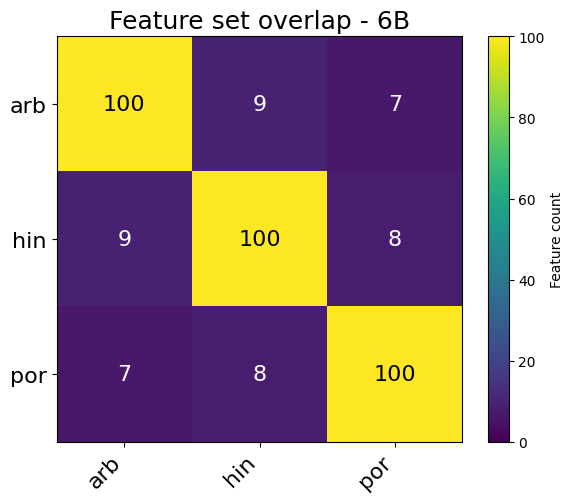

--------------------
effects_k:  m1_layer12_out
# of feats for both models for multiblimp_por_SV-G:  100
# of feats for both models for multiblimp_arb_SV-G:  100
# of feats for both models for multiblimp_hin_SV-G:  100


/tmp/ipykernel_4547/2792375173.py:28: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.

/tmp/ipykernel_4547/2792375173.py:28: FutureWarning:

You are using `torch.load` with `we

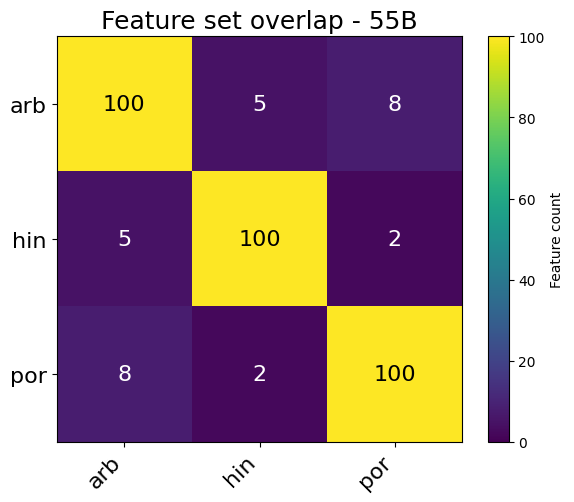

--------------------
effects_k:  m2_layer12_out
# of feats for both models for multiblimp_por_SV-G:  100
# of feats for both models for multiblimp_arb_SV-G:  100
# of feats for both models for multiblimp_hin_SV-G:  100


/tmp/ipykernel_4547/2792375173.py:28: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.

/tmp/ipykernel_4547/2792375173.py:28: FutureWarning:

You are using `torch.load` with `we

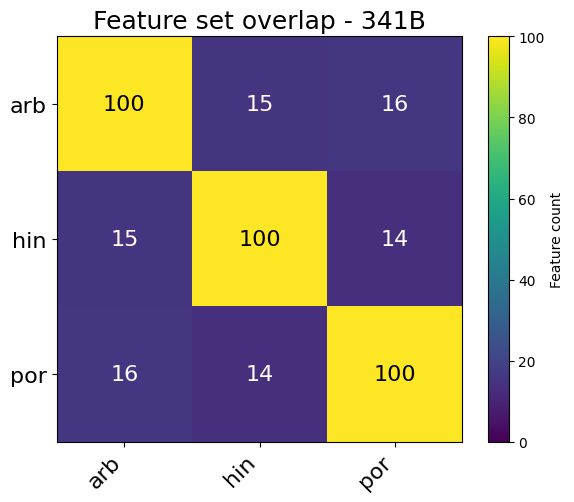

########################################
task:  SV-P
--------------------
version_num:  454
--------------------
effects_k:  m0_layer12_out
# of feats for both models for multiblimp_eng_SV-P:  100
# of feats for both models for multiblimp_fra_SV-P:  100
# of feats for both models for multiblimp_spa_SV-P:  100
# of feats for both models for multiblimp_por_SV-P:  100
# of feats for both models for multiblimp_arb_SV-P:  100
# of feats for both models for multiblimp_hin_SV-P:  100


/tmp/ipykernel_4547/2792375173.py:28: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.

/tmp/ipykernel_4547/2792375173.py:28: FutureWarning:

You are using `torch.load` with `we

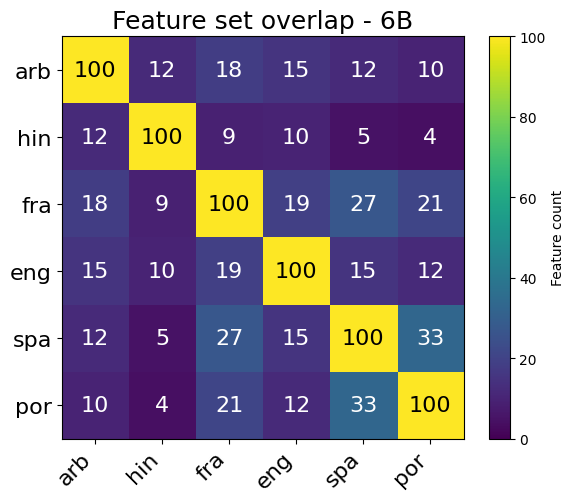

--------------------
effects_k:  m1_layer12_out
# of feats for both models for multiblimp_eng_SV-P:  100
# of feats for both models for multiblimp_fra_SV-P:  100
# of feats for both models for multiblimp_spa_SV-P:  100
# of feats for both models for multiblimp_por_SV-P:  100
# of feats for both models for multiblimp_arb_SV-P:  100
# of feats for both models for multiblimp_hin_SV-P:  100


/tmp/ipykernel_4547/2792375173.py:28: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.

/tmp/ipykernel_4547/2792375173.py:28: FutureWarning:

You are using `torch.load` with `we

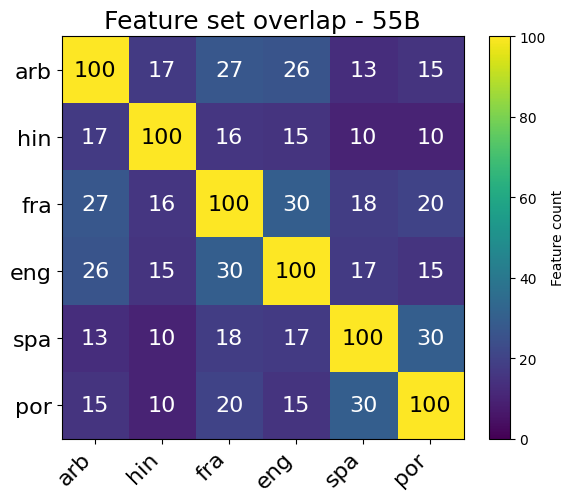

--------------------
effects_k:  m2_layer12_out
# of feats for both models for multiblimp_eng_SV-P:  100
# of feats for both models for multiblimp_fra_SV-P:  100
# of feats for both models for multiblimp_spa_SV-P:  100
# of feats for both models for multiblimp_por_SV-P:  100
# of feats for both models for multiblimp_arb_SV-P:  100
# of feats for both models for multiblimp_hin_SV-P:  100


/tmp/ipykernel_4547/2792375173.py:28: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.

/tmp/ipykernel_4547/2792375173.py:28: FutureWarning:

You are using `torch.load` with `we

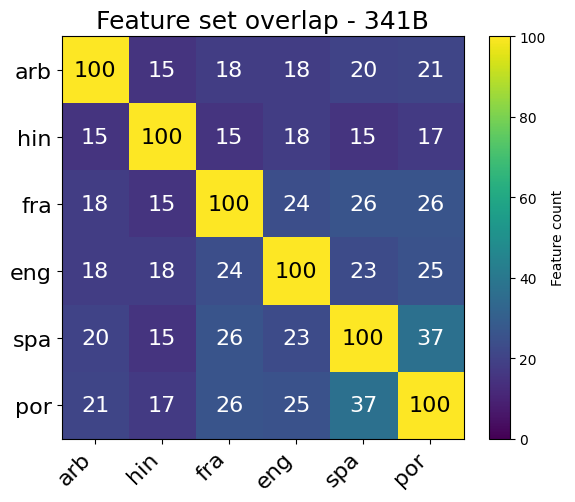

In [6]:
import torch
from collections import defaultdict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def get_feature_overlap_across_tasks_3way(
        task_list,
        version_num, 
        max_examples,
        submod_layer,
        node_threshold=0.1, 
        ckpt_num=20, 
        top_k=100,
        effects_k='m0_layer12_out'
    ):
    lang2fidset = {}
    lang2relie = {}
    fid2relie = {}
    fid2reldec = {}
        
    # (1) for all tasks in task_list
    for task in task_list:
        # (1.1) Load IE & Rel IE for all tasks in task_list
        base_dir = "./workspace/logs/ie_dicts_zeroshot"
        save_dir = f"{base_dir}/{version_num}"
        final_path = f"{save_dir}/{task}_ckpt{ckpt_num}_thresh{node_threshold}_n{max_examples}.pt"
        effects = torch.load(final_path)
        
        # (1.2) Make a dict of task -> feat_id set
        csv_path = f"{save_dir}/latents_{task}_ckpt{ckpt_num}_thresh{node_threshold}_n{max_examples}_topk10.csv"
        featdf = pd.read_csv(csv_path)
        lang = task.split("_")[1]
        fid2relie.update(dict(zip(f"{lang}-" + str(featdf['feat_id']), featdf['rel_ie_class'])))
        fid2reldec.update(dict(zip(f"{lang}-" + str(featdf['feat_id']), featdf['rel_dec_norm_class'])))
        
        all_top100_fids = set(
            torch.topk(effects[effects_k].abs(), k=top_k).indices.tolist()
        )
        print(f"# of feats for both models for {task}: ", len(all_top100_fids))
        
        lang2fidset[lang] = all_top100_fids
    
    fid2langset = defaultdict(set)
    for lang, fidset in lang2fidset.items():
        for fid in fidset:
            fid2langset[fid].add(lang)
    
    fid2multilangscore = {}
    for fid, langset in fid2langset.items():
        fid2multilangscore[fid] = len(langset)
    
    multilangscore_mean = np.array([len(langset) for fid, langset in fid2langset.items()]).mean()
    # print("Mean: ", multilangscore_mean)
    multilangscore_std = np.array([len(langset) for fid, langset in fid2langset.items()]).std()
    # print("Std: ", multilangscore_std)
    
    comparison = featdf["comparison"].unique().tolist()[0]
    
    return lang2fidset, comparison

def make_overlap_df(lang2fid, normalize=True):
    langs = sorted(lang2fid)
    if "fra" in langs:
        langs = ["arb", "hin", "fra", "eng", "spa", "por"]
    else:
        langs = ["arb", "hin", "por"]
    mat = np.zeros((len(langs), len(langs)), dtype=float)
    for i, la in enumerate(langs):
        for j, lb in enumerate(langs):
            inter = lang2fid[la] & lang2fid[lb]
            if normalize:
                union = lang2fid[la] | lang2fid[lb]
                mat[i, j] = len(inter) / len(union) if union else 0.0
            else:
                mat[i, j] = len(inter)
    return pd.DataFrame(mat, index=langs, columns=langs)

def plot_heatmap(df, top_k, title=None, save_path=None, fontsize=16):
    fig, ax = plt.subplots(figsize=(6, 5))
    im = ax.imshow(df.values, aspect='equal', vmin=0, vmax=top_k)
    ax.set_xticks(range(len(df.columns)))
    ax.set_xticklabels(df.columns, rotation=45, ha='right', fontsize=fontsize)
    ax.set_yticks(range(len(df.index)))
    ax.set_yticklabels(df.index, fontsize=fontsize)
    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label('Feature count')
    thresh = df.values.max() / 2.0
    for i in range(len(df)):
        for j in range(len(df)):
            val = df.values[i, j]
            text_color = "white" if val < thresh else "black"
            ax.text(
                j, i, f"{int(val)}",
                ha='center', va='center',
                color=text_color,
                fontsize=fontsize
            )
    if title:
        ax.set_title(title, fontsize=fontsize + 2)
    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path, bbox_inches='tight')
    plt.show()


langs=["eng", "fra", "spa", "por", "arb", "hin"]
svg_langs=["por", "arb", "hin"]

tasks=["SV-#", "SV-G", "SV-P"]
task2len = {
    "SV-#": 100,
    "SV-G": 100, 
    "SV-P": 290
}

for top_k in [10, 100]:
    for task in tasks:
        print("#" * 40)
        print("task: ", task)
        for version_num in ["454"]:
            print("-" * 20)
            print("version_num: ", version_num)
            effects_k_list = ['m0_layer12_out', 'm1_layer12_out', 'm2_layer12_out']
            for i, effects_k in enumerate(effects_k_list):
                print("-" * 20)
                print("effects_k: ", effects_k)
                if task == "SV-G":
                    task_list = [f"multiblimp_{lang}_{task}" for lang in svg_langs]
                else:
                    task_list = [f"multiblimp_{lang}_{task}" for lang in langs]
                lang2fid, comparison = get_feature_overlap_across_tasks_3way(
                    task_list=task_list,
                    version_num="version_" + version_num,
                    max_examples=task2len[task],
                    submod_layer=12,
                    top_k=top_k,
                    effects_k=effects_k
                )
                
                overlap_df = make_overlap_df(lang2fid, normalize=False)
                checkpoint_name = comparison.split(" vs. ")[i]
                
                final_path = f"figs/multilingual_overlap_3way/multilang_overlap_topk{top_k}_{task}_{i}"
                final_path = final_path.replace("#", "num")
                final_path = final_path.replace(" ", "_")
                final_path = final_path.replace(".", "")
                final_path += ".png"            
                plot_heatmap(overlap_df, top_k=top_k, title=f"Feature set overlap - {checkpoint_name}", save_path=final_path)
        
        

## Annotation Table Pythia 3-way

In [7]:
out = table_generator_three_way(
    version_num    = 446,
    model_name     = "Pythia-1B"
)
print(out)

\begin{table*}[!ht]
\centering
\resizebox{1.0\linewidth}{!}{%
\begin{tabular}{crl}
\toprule
\mythead{\relie{}} & \mythead{FeatID} & \mythead{Interpreted Function} \\
\midrule
\multicolumn{3}{l}{\bfseries 1B-4B shared} \\
\midrule
$[0.32,\;0.43,\;0.25]$ & 15204 & detects singular nouns found in technical discourse (method, function, guide, recipe) preceeded by the word "This" \\
$[0.53,\;0.33,\;0.15]$ & 1067 & detects subtoken "ans" typically in names \\
$[0.41,\;0.39,\;0.20]$ & 941 & detects plural nouns that are art-related prfoessions \\
$[0.45,\;0.41,\;0.14]$ & 4897 & detects plural nouns that end with "ists", (e.g. protagonist, capitalist, pharmacist) \\
\multicolumn{3}{l}{\bfseries 1B-286B shared} \\
\midrule
$[0.52,\;0.03,\;0.45]$ & 1641 & detects newlines \\
$[0.52,\;0.01,\;0.46]$ & 3852 & detects singular "man" noun \\
$[0.55,\;0.10,\;0.34]$ & 7489 & detects singular woman \\
\multicolumn{3}{l}{\bfseries 4B specific} \\
\midrule
$[0.00,\;1.00,\;0.00]$ & 15556 & detects a full s

/mnt/u14157_ic_nlp_001_files_nfs/nlpdata1/home/bayazit/model-diff/vis.py:936: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



## Annotation Table OLMo 3-way

In [8]:
out = table_generator_three_way(
    version_num    = 447,
    model_name     = "OLMo-1B"
)
print(out)

\begin{table*}[!ht]
\centering
\resizebox{1.0\linewidth}{!}{%
\begin{tabular}{crl}
\toprule
\mythead{\relie{}} & \mythead{FeatID} & \mythead{Interpreted Function} \\
\midrule
\multicolumn{3}{l}{\bfseries 4B specific} \\
\midrule
$[1.00,\;0.00,\;0.00]$ & 675 & regular plural noun detector, activates on  final tokens of regular plural nouns and promotes new word completions \\
$[1.00,\;0.00,\;0.00]$ & 10707 & - \\
$[0.99,\;0.00,\;0.01]$ & 8433 & - \\
$[1.00,\;0.00,\;0.00]$ & 15961 & norminalization neuron that detects deverbal and derivational nouns (i.e. -ance, -ion, -ing, -ment, -er, -ship, etc.) \\
\multicolumn{3}{l}{\bfseries 4B-33B shared} \\
\midrule
$[0.36,\;0.34,\;0.30]$ & 702 & plural noun detector preceeded by plural quantifier, promotes plural verb conjugation \\
\multicolumn{3}{l}{\bfseries 4B-3048B shared} \\
\midrule
$[0.38,\;0.25,\;0.37]$ & 16117 & stock‐ticker/exchange‐code detector \\
\multicolumn{3}{l}{\bfseries 33B specific} \\
\midrule
$[0.00,\;1.00,\;0.00]$ & 5966 & 

/mnt/u14157_ic_nlp_001_files_nfs/nlpdata1/home/bayazit/model-diff/vis.py:936: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



## Annotation Table BLOOM 3-way (CLAMS & MultiBLiMP)

In [9]:
for task_name in ["clams_fraeng", "multiblimp_eng", "multiblimp_fra", "multiblimp_hin"]:
    out = table_generator_three_way_bloom(
        annotation_filename = f"annotation_{task_name}.csv",
        version_num         = 454,
        model_name          = "BLOOM-1B"
    )
    print(out)
    print("\n\n\n\n\n\n")

\begin{table*}[!ht]
\centering
\resizebox{1.0\linewidth}{!}{%
\begin{tabular}{crll}
\toprule
\mythead{\relie{}} & \mythead{FeatID} & \mythead{Interpreted Function} & \mythead{Languages} \\
\midrule
\multicolumn{4}{l}{\bfseries 6B specific} \\
\midrule
$[1.00,\;0.00,\;0.00]$ & 3672 & Detects ellipsis and question/exclamation marks & arb,eng,fra,hin,por,spa \\
$[0.78,\;0.14,\;0.07]$ & 7122 & Main-verb head detector & eng \\
$[0.83,\;0.14,\;0.03]$ & 10388 & Plural noun detector for several languages (e.g. players, usários - users, al naas - the people, {\dn mEhlAe{\qva}} - ladies) & arb,eng,fra,hin,por,spa \\
$[0.72,\;0.23,\;0.06]$ & 9163 & Noun‑phrase head detector of multi‑word noun chunk, activates on the key content (noun or adjective) that carries the meaning & eng,fra,por,spa \\
\multicolumn{4}{l}{\bfseries 6B-55B shared} \\
\midrule
$[0.35,\;0.41,\;0.24]$ & 15248 & Detects "that" token only in English & eng \\
$[0.36,\;0.36,\;0.28]$ & 12525 & Boss concept detector (e.g. chief, chef

/mnt/u14157_ic_nlp_001_files_nfs/nlpdata1/home/bayazit/model-diff/vis.py:1236: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/mnt/u14157_ic_nlp_001_files_nfs/nlpdata1/home/bayazit/model-diff/vis.py:1236: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/mnt/u14157_ic_nlp_001_files_nfs/nlpdata1/home/bayazit/model-diff/vis.py:1236: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/mnt/u14157_ic_nlp_001_files_nfs/nlpdata1/home/ba

## Annotation Table Pythia 2-way

In [10]:
out = table_generator_two_way(
    annotation_filename = f"workspace/annotation_pythia_2way_blimp.csv",
    model_name          = "Pythia-1B"
)
print(out)

\begin{table*}[!ht]
\centering
\resizebox{1.0\linewidth}{!}{%
\begin{tabular}{crl}
\toprule
\mythead{\relie{}} & \mythead{FeatID} & \mythead{Interpreted Function} \\
\midrule
\multicolumn{3}{l}{\bfseries Comparison: 128M \compar{} 1B} \\
\midrule
\multicolumn{3}{l}{\itshape 128M specific} \\
\midrule
$0.19$ & 5667 & - \\
$0.28$ & 14250 & detects token "ese" at the end \\
$0.29$ & 440 & detects token "ara" at the end of a name, promotes possesion or verbs \\
\multicolumn{3}{l}{\itshape 128M-1B shared} \\
\midrule
$0.38$ & 8636 & - \\
$0.43$ & 3164 & detects "us" ending, often at the end of latin single noun and promotes "is"  \\
$0.52$ & 12683 & detects the noun "analysis"  \\
$0.53$ & 1749 & detects "people" \\
$0.56$ & 5032 & detects "men" plural promotes EOS, conjuction, or verbs, and demotes "like" which can create separate clauses \\
$0.57$ & 7072 & - \\
\multicolumn{3}{l}{\itshape 1B specific} \\
\midrule
$0.71$ & 15882 & detects "man" singular, promotes preposition completion \\


/mnt/u14157_ic_nlp_001_files_nfs/nlpdata1/home/bayazit/model-diff/vis.py:1064: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/mnt/u14157_ic_nlp_001_files_nfs/nlpdata1/home/bayazit/model-diff/vis.py:1064: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/mnt/u14157_ic_nlp_001_files_nfs/nlpdata1/home/bayazit/model-diff/vis.py:1064: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



## Annotation Table BLOOM 2-way

In [11]:
out = table_generator_two_way_bloom(
    annotation_filename = f"workspace/annotation_bloom_2way_clamsfraeng.csv",
    model_name          = "BLOOM-1B"
)
print(out)

\begin{table*}[!ht]
\centering
\resizebox{1.0\linewidth}{!}{%
\begin{tabular}{crll}
\toprule
\mythead{\relie{}} & \mythead{FeatID} & \mythead{Interpreted Function} & \mythead{Languages} \\
\midrule
\multicolumn{4}{l}{\bfseries Comparison: 550M \compar{} 6B} \\
\midrule
\multicolumn{4}{l}{\itshape 550M specific} \\
\midrule
$0.00$ & 8760 & detects administive/government-related nouns & fra \\
$0.00$ & 14133 & detects nouns and verbs that convey key actions, entities, or ideas in a sentence & eng \\
$0.05$ & 12275 & detects conjuction "et" & fra \\
$0.10$ & 8341 & detects subtoken "et" typically conjunction but also sometimes for "et al." & fra \\
$0.20$ & 15852 & head nouns and their modifiers that signal prominent participants or components & fra \\
$0.22$ & 14697 & detects plural nouns, promotes plural verb conjugation and "who" pronoun & eng,fra,spa \\
\multicolumn{4}{l}{\itshape 550M-6B shared} \\
\midrule
$0.36$ & 1474 & detects plural articles "les", "nos", "certains", promotes pl

/mnt/u14157_ic_nlp_001_files_nfs/nlpdata1/home/bayazit/model-diff/vis.py:1376: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/mnt/u14157_ic_nlp_001_files_nfs/nlpdata1/home/bayazit/model-diff/vis.py:1376: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/mnt/u14157_ic_nlp_001_files_nfs/nlpdata1/home/bayazit/model-diff/vis.py:1376: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



## RelIE & RelDec Corr with Delta M1 Patch / Delta M2 Patch

In [12]:
def clean_scatter(df, x_col, y_col):
    x = df[x_col]
    y = df[y_col]
    
    # compute z-scores for y
    z_scores = stats.zscore(y)
    abs_z = abs(z_scores)

    # filter (e.g. keep only |z| < 3)
    df = df[abs_z < 3]
    
    x = df[x_col]
    y = df[y_col]

    plt.figure()
    plt.scatter(x, y)
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.ylim(0,10)
    plt.title(f'{y_col} vs {x_col}')
    plt.show()

def gather_corr_results(top_k, version_list, model_name, do_corr_plot=False):
    base_dir = "./workspace/logs/ie_dicts_zeroshot"
    subtasks = [
        "distractor_agreement_relational_noun",
        "distractor_agreement_relative_clause",
        "irregular_plural_subject_verb_agreement_1",
        "regular_plural_subject_verb_agreement_1"
    ]
    subtask2name = {
        "subjectverb-distractor_agreement_relational_noun": "\\texttt{Distractor Relational Noun}",
        "subjectverb-distractor_agreement_relative_clause": "\\texttt{Distractor Relative Clause}",
        "subjectverb-irregular_plural_subject_verb_agreement_1": "\\texttt{Irregular Plural Subject}",
        "subjectverb-regular_plural_subject_verb_agreement_1": "\\texttt{Regular Plural Subject}",
        
    }
    
    # Collect DataFrames in a list, then concatenate
    all_dfs = []
    plt_cnt = 0
    for version_num in version_list:
        save_dir = os.path.join(base_dir, "version_" + str(version_num))
        for subtask in subtasks:
            corr_path = os.path.join(
                save_dir,
                f"ablation-task_subjectverb-{subtask}-topk{top_k}-corr.csv"
            )
            if os.path.isfile(corr_path):
                df = pd.read_csv(corr_path)
                all_dfs.append(df)
            else:
                print(f"Warning: file not found: {corr_path}")
            
            if do_corr_plot and plt_cnt < 2:
                summary_path = os.path.join(
                    save_dir,
                    f"ablation-task_subjectverb-{subtask}-topk{top_k}-deltasummary.csv"
                )
                if os.path.isfile(corr_path):
                    summary_df = pd.read_csv(summary_path)
                    clean_scatter(df=summary_df, y_col="LogProbDiff Δ Ratio Abs(M2/M1)", x_col="RelDec")
                    clean_scatter(df=summary_df, y_col="LogProbDiff Δ Ratio Abs(M2/M1)", x_col="RelIE")
                    plt_cnt += 1
                else:
                    print(f"Warning: file not found: {corr_path}")

    # Concatenate all (will append rows)
    if all_dfs:
        combined = pd.concat(all_dfs, ignore_index=True)
        combined["task"] = combined["task"].replace(subtask2name)
        combined = combined[['comparison', 'task', 'rho(Δ Ratio Abs(M2/M1) - RelDec)',
       'rho(Δ Ratio Abs(M2/M1) - RelIE)']]
        
        # write out a single CSV
        output_path = os.path.join(".",  "workspace", "results", f"combined_ablation_corr_{model_name}_topk{top_k}.csv")
        combined.to_csv(output_path, index=False)
        print(f"Combined CSV written to: {output_path}")
        
        # write out a single LaTeX
        num_cols = [
            'rho(Δ Ratio Abs(M2/M1) - RelDec)',
            'rho(Δ Ratio Abs(M2/M1) - RelIE)'
        ]
        
        group_means = (
            combined
            .groupby('comparison')[num_cols]
            .mean()
            .reset_index()
        )
        # label them
        group_means['comparison'] = 'Avg ' + group_means['comparison']
        group_means['task'] = '-'
        # make sure columns are in the same order
        group_means = group_means[['comparison', 'task'] + num_cols]

        # compute overall average
        overall = combined[num_cols].mean().to_frame().T
        overall['comparison'] = 'Avg'
        overall['task'] = '-'
        overall = overall[['comparison','task'] + num_cols]
        
        final = pd.concat([combined, group_means, overall], ignore_index=True)
        print(final.to_latex(index=False, float_format="%.3f"))
    else:
        print("No CSV files were loaded. Check your paths.")
        
gather_corr_results(top_k=10, version_list=[218, 265, 219], model_name="pythia", do_corr_plot=False)
gather_corr_results(top_k=10, version_list="440 430 434 433 436".split(" "), model_name="olmo", do_corr_plot=False)

Combined CSV written to: ./workspace/results/combined_ablation_corr_pythia_topk10.csv
\begin{tabular}{llrr}
\toprule
comparison & task & rho(Δ Ratio Abs(M2/M1) - RelDec) & rho(Δ Ratio Abs(M2/M1) - RelIE) \\
\midrule
128M vs. 1B & \texttt{Distractor Relational Noun} & 0.316 & 0.934 \\
128M vs. 1B & \texttt{Distractor Relative Clause} & 0.788 & 0.966 \\
128M vs. 1B & \texttt{Irregular Plural Subject} & 0.941 & 0.979 \\
128M vs. 1B & \texttt{Regular Plural Subject} & 0.794 & 0.948 \\
1B vs. 4B & \texttt{Distractor Relational Noun} & 0.930 & 0.958 \\
1B vs. 4B & \texttt{Distractor Relative Clause} & 0.901 & 0.922 \\
1B vs. 4B & \texttt{Irregular Plural Subject} & 0.777 & 0.937 \\
1B vs. 4B & \texttt{Regular Plural Subject} & 0.874 & 0.930 \\
4B vs. 286B & \texttt{Distractor Relational Noun} & 0.691 & 0.964 \\
4B vs. 286B & \texttt{Distractor Relative Clause} & 0.784 & 0.941 \\
4B vs. 286B & \texttt{Irregular Plural Subject} & 0.843 & 0.954 \\
4B vs. 286B & \texttt{Regular Plural Subject} &